In [1]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv(r"C:\INES\chp\fuel\2023_12-2025_01_Gaszaehler_BHKW.csv", sep = ';')

In [3]:
df['0'] = pd.to_datetime(df['0'])
df.set_index('0', inplace=True)

In [4]:
df_dec = df['2024-12-01':'2024-12-15']

In [5]:
df_dec['Fuel_chp2'] = df_dec['Durlach_Heizzentrale_zlGZBHKW2energy'].diff()


C:\Users\Aqib\AppData\Local\Temp\ipykernel_19856\3622232995.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dec['Fuel_chp2'] = df_dec['Durlach_Heizzentrale_zlGZBHKW2energy'].diff()


In [6]:
df_dec['Fuel_chp2'] = df_dec['Fuel_chp2'].shift(-1) # moving all the values up once,to have it left oriented

C:\Users\Aqib\AppData\Local\Temp\ipykernel_19856\4213372064.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dec['Fuel_chp2'] = df_dec['Fuel_chp2'].shift(-1) # moving all the values up once,to have it left oriented


In [7]:
csv_files = glob.glob(r"C:\INES\chp\chp_data_oneyear\chp_data_oneyear\December/*csv")


energy_df = pd.DataFrame()

for i,file in enumerate(csv_files):
    temp_df = pd.read_csv(file, encoding = 'cp1252',sep = ';', skiprows=1)
    energy_df = pd.concat([energy_df,temp_df])

In [8]:
energy_df['Description'] = pd.to_datetime(energy_df['Description'])
energy_df.set_index('Description', inplace=True)

In [9]:
energy_df = energy_df['2024-12-01':'2024-12-15']

C:\Users\Aqib\AppData\Local\Temp\ipykernel_19856\1264533149.py:1: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  energy_df = energy_df['2024-12-01':'2024-12-15']


In [10]:
df_dec = df_dec.join(energy_df['Heizleistung BHKW 2 (Heizzentrale)'], how = 'inner') # join, because common index

In [11]:
# converting to watts
df_dec['Heizleistung BHKW 2 (Heizzentrale)'] = df_dec['Heizleistung BHKW 2 (Heizzentrale)'] * 1000

In [12]:
df_dec.iloc[-1]

Durlach_Heizzentrale_zlGZBHKW1energy    132373.0
Durlach_Heizzentrale_zlGZBHKW2energy    166803.0
Fuel_chp2                                    NaN
Heizleistung BHKW 2 (Heizzentrale)           0.0
Name: 2024-12-15 23:59:00, dtype: float64

In [13]:
df_dec = df_dec.resample('H').sum()

In [14]:
df_dec['Heizleistung BHKW 2 (Heizzentrale)'] = df_dec['Heizleistung BHKW 2 (Heizzentrale)'] * (1/60) # 1 min to 1 hr timestep

In [15]:
df_dec['Consumption m^3/wh'] = np.where(df_dec['Heizleistung BHKW 2 (Heizzentrale)'] != 0, df_dec['Fuel_chp2']/df_dec['Heizleistung BHKW 2 (Heizzentrale)'], np.nan)

In [16]:
df_dec['Consumption Litres/wh'] = df_dec['Consumption m^3/wh']*1000

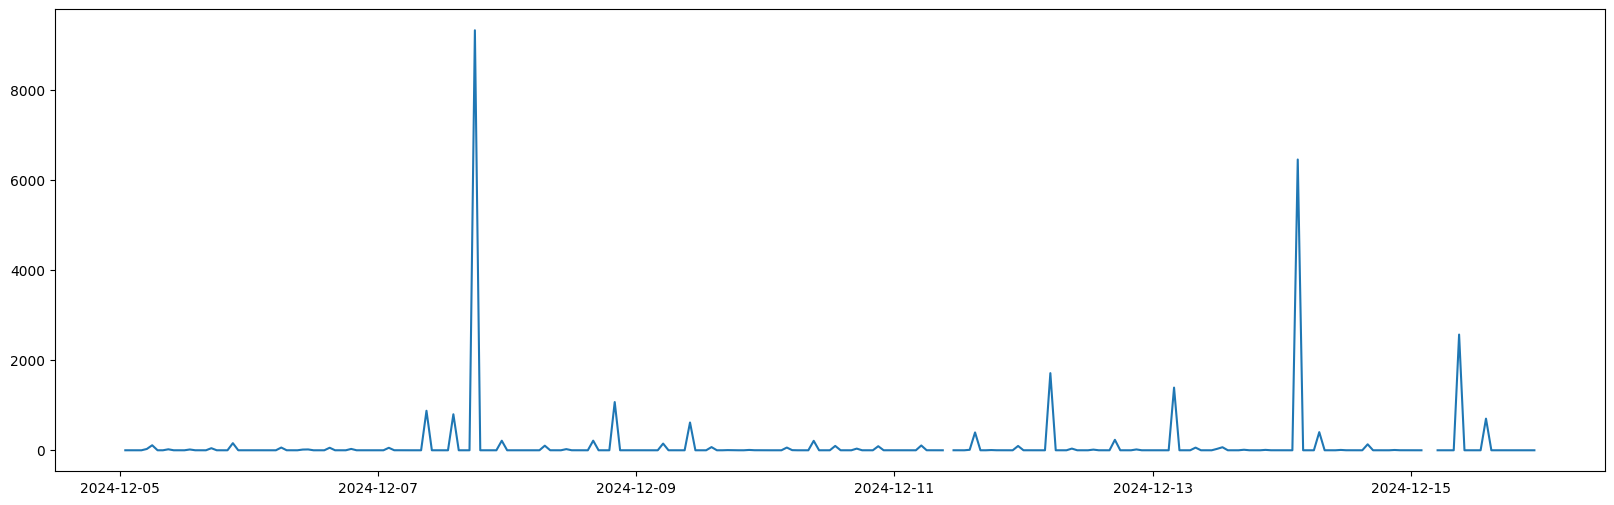

In [17]:
plt.figure(figsize=[20,6])
plt.plot(df_dec['Consumption Litres/wh'])

In [18]:
df.loc['2024-12-05 02:00:00', 'Durlach_Heizzentrale_zlGZBHKW2energy'] - df.loc['2024-12-05 01:00:00', 'Durlach_Heizzentrale_zlGZBHKW2energy']


11.0

In [19]:
df_dec['Consumption Litres/wh'].mean()

111.9876933554458

In [20]:
Q1 = df_dec['Consumption Litres/wh'].quantile(0.25)
Q3 = df_dec['Consumption Litres/wh'].quantile(0.75)
IQR = Q3 - Q1

# Filter out outliers
df_filtered = df_dec[(df_dec['Consumption Litres/wh'] >= (Q1 - 1.5 * IQR)) & (df_dec['Consumption Litres/wh'] <= (Q3 + 1.5 * IQR))]

# Calculate mean without outliers
mean_fuel_efficiency = df_filtered['Consumption Litres/wh'].mean()
print(mean_fuel_efficiency, IQR)


0.08344418323673508 0.48304684644026336


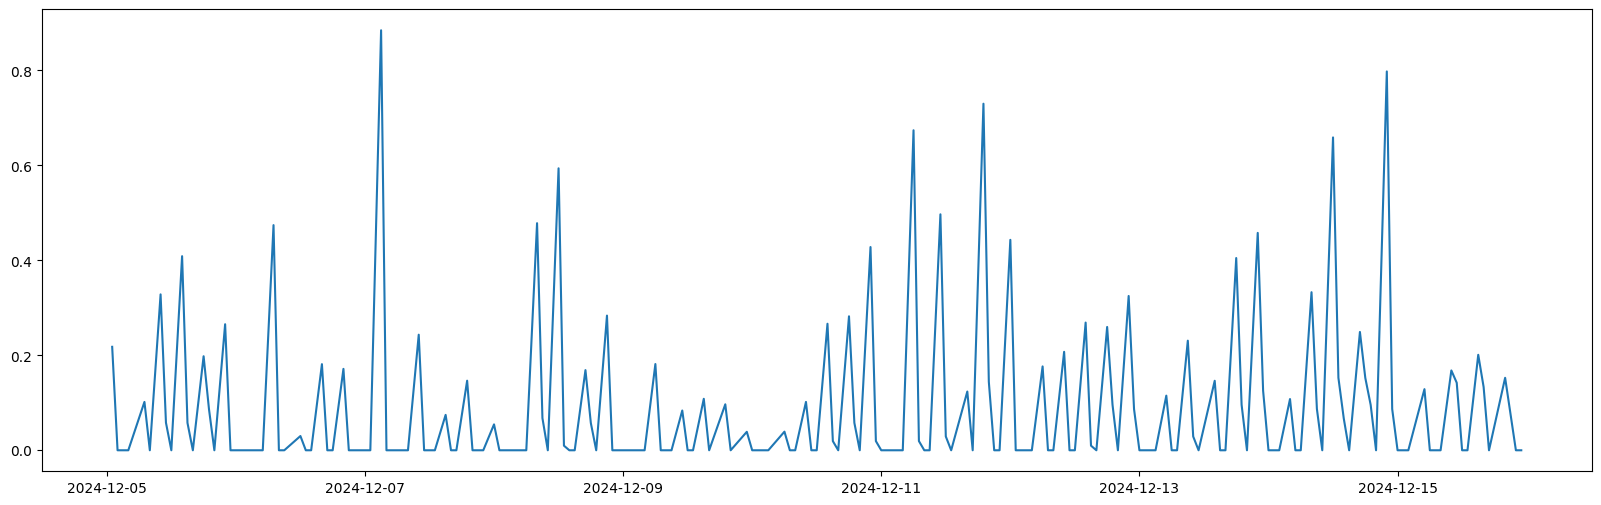

In [22]:
plt.figure(figsize=[20,6])
plt.plot(df_filtered['Consumption Litres/wh'])